In [38]:
from torchsig.datasets.wideband_sig53 import WidebandSig53
from torchmetrics.detection import MeanAveragePrecision
from torch.utils.data import DataLoader
from torchsig.transforms.target_transforms import DescToBBoxSignalDict, ListTupleToDesc
from torchsig.transforms.transforms import Spectrogram, Normalize, Compose, Identity
from torchsig.models.spectrogram_models.detr.modules import SetCriterion
from torchsig.models.spectrogram_models.detr.detr import detr_b0_nano, format_preds, format_targets
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import pandas as pd
import numpy as np
import torch
import time
import os

from torchsig.utils.visualize import MaskClassVisualizer, mask_class_to_outline, complex_spectrogram_to_magnitude
from torchsig.transforms.target_transforms import DescToMaskClass, DescToListTuple
from torchsig.transforms import Spectrogram, Normalize
from torchsig.utils.writer import DatasetCreator, DatasetLoader
from torchsig.datasets.wideband_sig53 import WidebandSig53
from torchsig.datasets.wideband import WidebandModulationsDataset
from torchsig.transforms.transforms import Compose
from torchsig.datasets import conf
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [23]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [27]:
# cfg = conf.WidebandSig53CleanValQAConfig
cfg = conf.WidebandSig53ImpairedValQAConfig

wideband_ds = WidebandModulationsDataset(
    level=cfg.level,
    num_iq_samples=cfg.num_iq_samples,
    num_samples=cfg.num_samples,
    target_transform=DescToListTuple(),
    seed=cfg.seed,
)

dataset_loader = DatasetLoader(
    wideband_ds,
    seed=12345678,
    collate_fn=collate_fn
)
creator = DatasetCreator(
    wideband_ds,
    seed=12345678,
    path="wideband_sig53/wideband_sig53_impaired_val",
    loader=dataset_loader,
)
creator.create()

  0%|          | 0/3 [00:00<?, ?it/s]

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

In [32]:
cfg = conf.WidebandSig53ImpairedTrainQAConfig
# cfg = conf.WidebandSig53CleanTrainConfig

wideband_ds = WidebandModulationsDataset(
    level=cfg.level,
    num_iq_samples=cfg.num_iq_samples,
    num_samples=cfg.num_samples,
    target_transform=DescToListTuple(),
    seed=cfg.seed,
) 

dataset_loader = DatasetLoader(
    wideband_ds,
    seed=12345678,
    collate_fn=collate_fn
)
creator = DatasetCreator(
    wideband_ds,
    seed=12345678,
    path="wideband_sig53/wideband_sig53_impaired_train",
    loader=dataset_loader,
)
creator.create()

  0%|          | 0/31 [00:00<?, ?it/s][W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (fun

In [42]:
# Specify WidebandSig53 Options
root = 'wideband_sig53/'
fft_size = 512

transform = Compose([
    Spectrogram(nperseg=fft_size, noverlap=0, nfft=fft_size, mode='complex'),
    Normalize(norm=np.inf, flatten=True),
])

target_transform = Compose([
    ListTupleToDesc(),
    DescToBBoxSignalDict()
])

# Instantiate the training WidebandSig53 Dataset
wideband_sig53_train = WidebandSig53(
    root=root, 
    train=True, 
    impaired=True,
    transform=transform,
    target_transform=target_transform,
    use_signal_data=False,
)

# Instantiate the validation WidebandSig53 Dataset
wideband_sig53_val = WidebandSig53(
    root=root, 
    train=False, 
    impaired=True,
    transform=transform,
    target_transform=target_transform,
    use_signal_data=False,
)

# Retrieve a sample and print out information
idx = np.random.randint(len(wideband_sig53_val))
data, label = wideband_sig53_val[idx]
print("Training Dataset length: {}".format(len(wideband_sig53_train)))
print("Validation Dataset length: {}".format(len(wideband_sig53_val)))
print("Data shape: {}".format(data.shape))
print("Label: {}".format(label))

Training Dataset length: 250
Validation Dataset length: 25
Data shape: (2, 512, 512)
Label: {'labels': tensor([0]), 'boxes': tensor([[0.5000, 0.5000, 0.5000, 0.5000]])}


In [36]:
def collate_fn(batch):
    return tuple(zip(*batch))

# Create dataloaders
train_dataloader = DataLoader(
    dataset=wideband_sig53_train,
    batch_size=4,
    num_workers=0,
    shuffle=True,
    drop_last=True,
    collate_fn=collate_fn,
)

val_dataloader = DataLoader(
    dataset=wideband_sig53_val,
    batch_size=4,
    num_workers=0,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
)

In [32]:
model = detr_b0_nano(
    pretrained=False,
)

device = torch.device("mps")
model = model.to(device)

In [37]:

class ExampleDETR(pl.LightningModule):
    def __init__(self, model, data_loader, val_data_loader):
        super(ExampleDETR, self).__init__()
        self.mdl = model
        self.data_loader = data_loader
        self.val_data_loader = val_data_loader
        self.loss_fn = SetCriterion()
        
        # Hyperparameters
        self.lr = 0.001
        self.batch_size = data_loader.batch_size
        
    def forward(self, x):
        return self.mdl(x)

    def predict(self, x):
        with torch.no_grad():
            out = self.forward(x)
        return out
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    
    def train_dataloader(self):
        return self.data_loader
    
    def training_step(self, batch, _):
        x, y = batch
        x = torch.stack([torch.as_tensor(xi, device="mps") for xi in x], dim=0)
        y_hat = self.forward(x)
        loss_vals = self.loss_fn(y_hat, y)
        loss = self.loss_fn.weight_dict["loss_ce"] * loss_vals["loss_ce"] + \
            self.loss_fn.weight_dict["loss_bbox"] * loss_vals["loss_bbox"] + \
            self.loss_fn.weight_dict["loss_giou"] * loss_vals["loss_giou"]
        return {'loss':loss}
    
    def val_dataloader(self):
        return self.val_data_loader
    
    def validation_step(self, batch, _):
        x, y = batch
        x = torch.stack([torch.as_tensor(xi, device="mps") for xi in x], dim=0)
        y_hat = self.forward(x)
        loss_vals = self.loss_fn(y_hat, y)
        loss = self.loss_fn.weight_dict["loss_ce"] * loss_vals["loss_ce"] + \
            self.loss_fn.weight_dict["loss_bbox"] * loss_vals["loss_bbox"] + \
            self.loss_fn.weight_dict["loss_giou"] * loss_vals["loss_giou"]
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True, batch_size=4)
        return {'val_loss': loss}
        
example_model = ExampleDETR(model, train_dataloader, val_dataloader)

In [34]:

# Setup checkpoint callbacks
checkpoint_filename = "{}/checkpoints/checkpoint".format(os.getcwd())
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename=checkpoint_filename,
    save_top_k=True,
    verbose=True,
    monitor="val_loss",
    mode="min",
)

# Create and fit trainer
epochs = 50
trainer = pl.Trainer(
    max_epochs=epochs,
    callbacks=checkpoint_callback,
    accelerator="gpu",
    devices=[0],
    accumulate_grad_batches=4,
)
trainer.fit(example_model)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type         | Params
-----------------------------------------
0 | mdl     | DETRModel    | 8.2 M 
1 | loss_fn | SetCriterion | 0     
-----------------------------------------
8.2 M     Trainable params
0         Non-trainable params
8.2 M     Total params
32.721    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/devjyotidas/anaconda3/envs/torch/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


TypeError: 'SignalDescription' object is not iterable

In [68]:
# Load best checkpoint
checkpoint = torch.load(checkpoint_filename+".ckpt", map_location=lambda storage, loc: storage)
example_model.load_state_dict(checkpoint['state_dict'])
example_model = example_model.eval()

In [69]:
preds = {}
data_collection = {}
label_collection = {}
results_collection = {}

threshold = 0.8
fft_size = 512

num_eval = 6
for p in range(num_eval):
    # Retrieve data
    idx = np.random.randint(len(wideband_sig53_val))
    data, label = wideband_sig53_val[idx]
    data_collection[p] = data
    
    # Infer
    with torch.no_grad():
        data = torch.from_numpy(np.expand_dims(data,0)).float()
        data = data.cuda() if torch.cuda.is_available() else data
        pred = example_model(data)
    preds[p] = pred
    
    # Convert output to detections dataframe
    component_num = 0
    column_names = ["DetectionIdx", "Probability", "CenterTimePixel", "DurationPixel", "CenterFreqPixel", "BandwidthPixel", "Class"]
    detected_signals_df = pd.DataFrame(columns = column_names)
    
    # Loop over the number of objects DETR outputs
    for obj_idx in range(pred['pred_logits'].shape[1]):
        probs = pred['pred_logits'][0][obj_idx].softmax(-1)
        max_prob = probs.max().cpu().detach().numpy()
        max_class = probs.argmax().cpu().detach().numpy()
        
        # If max class is not the last class for no object, interpret values
        if max_class != (pred['pred_logits'].shape[2] - 1) and max_prob > threshold:
            center_time = pred['pred_boxes'][0][obj_idx][0]
            center_freq = pred['pred_boxes'][0][obj_idx][1]
            duration = pred['pred_boxes'][0][obj_idx][2]
            bandwidth = pred['pred_boxes'][0][obj_idx][3]
        
            # Save to dataframe
            detected_signals_df.at[component_num,"DetectionIdx"] = component_num
            detected_signals_df.at[component_num,"Probability"] = max_prob
            detected_signals_df.at[component_num,"CenterTimePixel"] = center_time.cpu().detach().numpy() * fft_size
            detected_signals_df.at[component_num,"DurationPixel"] = duration.cpu().detach().numpy() * fft_size
            detected_signals_df.at[component_num,"CenterFreqPixel"] = center_freq.cpu().detach().numpy() * fft_size
            detected_signals_df.at[component_num,"BandwidthPixel"] = bandwidth.cpu().detach().numpy() * fft_size
            detected_signals_df.at[component_num,"Class"] = max_class
            component_num += 1

    # Save to results collection
    results_collection[p] = detected_signals_df
    
        # Convert label to labels dataframe
    component_num = 0
    labels_df = pd.DataFrame(columns = column_names)
    
    for label_obj_idx in range(len(label['labels'])):
        center_time = label["boxes"][label_obj_idx][0]
        center_freq = label["boxes"][label_obj_idx][1]
        duration = label["boxes"][label_obj_idx][2]
        bandwidth = label["boxes"][label_obj_idx][3]
        class_name = label["labels"][label_obj_idx]

        # Save to dataframe
        labels_df.at[component_num,"DetectionIdx"] = component_num
        labels_df.at[component_num,"Probability"] = 1.0
        labels_df.at[component_num,"CenterTimePixel"] = center_time * fft_size
        labels_df.at[component_num,"DurationPixel"] = duration * fft_size
        labels_df.at[component_num,"CenterFreqPixel"] = center_freq * fft_size
        labels_df.at[component_num,"BandwidthPixel"] = bandwidth * fft_size
        labels_df.at[component_num,"Class"] = class_name
        component_num += 1

    # Save to label collection
    label_collection[p] = labels_df


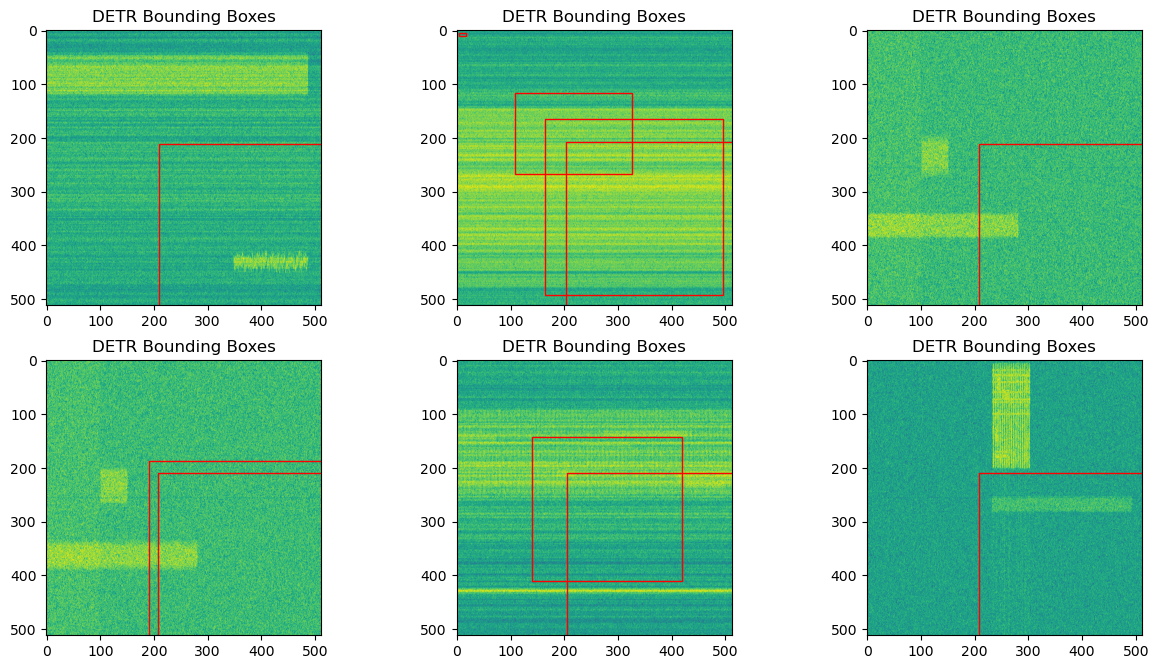

In [70]:
include_annotation = False

plt.figure(figsize=(15, 25))
for i in range(num_eval):
    ax = plt.subplot(num_eval,3,i+1)
    
    # Convert complex spectrogram to magnitude for plotting
    data_plot = np.squeeze(data_collection[i])
    data_plot = data_plot[0]**2 + data_plot[1]**2
    data_plot = 20*np.log10(data_plot)

    # Retrieve individual label
    ax.imshow(data_plot)
    for sig_idx in range(results_collection[i].shape[0]):
        rect = mpl.patches.Rectangle(
            (results_collection[i].iloc[sig_idx]["CenterTimePixel"]-results_collection[i].iloc[sig_idx]["DurationPixel"]/2,
             results_collection[i].iloc[sig_idx]["CenterFreqPixel"]-results_collection[i].iloc[sig_idx]["BandwidthPixel"]/2),
            results_collection[i].iloc[sig_idx]["DurationPixel"],
            results_collection[i].iloc[sig_idx]["BandwidthPixel"],
            linewidth=1,
            edgecolor='r',
            facecolor='none'
        )
        ax.add_patch(rect)
        
        if include_annotation:
            ax.annotate(
                "{:.1f}%".format(results_collection[i].iloc[sig_idx]["Probability"]*100), 
                (
                    results_collection[i].iloc[sig_idx]["CenterTimePixel"]+results_collection[i].iloc[sig_idx]["DurationPixel"]/2, 
                    results_collection[i].iloc[sig_idx]["CenterFreqPixel"]-results_collection[i].iloc[sig_idx]["BandwidthPixel"]/2
                ), 
                color='w', 
                weight='bold', 
                fontsize=8, 
                ha='right', 
                va='bottom',
             )
        
    plt.title("DETR Bounding Boxes")
plt.show()

In [72]:
mAP_metric = MeanAveragePrecision(class_metrics=False)

fft_size = 512
batch_size = 32
num_eval = len(wideband_sig53_val)
data_idx = 0

fp16 = True

model = model.eval().to(device)
if fp16:
    # Note: only the backbone supports fp16 precision at this time
    model.backbone = model.backbone.half()
    model.conv = model.conv.half()
    model.transformer = model.transformer.float()
    model.linear_class = model.linear_class.float()
    model.linear_bbox = model.linear_bbox.float()
else:
    model.backbone = model.backbone.float()
    model.conv = model.conv.float()
    model.transformer = model.transformer.float()
    model.linear_class = model.linear_class.float()
    model.linear_bbox = model.linear_bbox.float()

for curr_batch in tqdm(range(num_eval // batch_size)):
    # Create batch
    batch = np.zeros((batch_size, 2, fft_size, fft_size))
    label_batch = []
    for batch_element in range(batch_size):
        # Retrieve data
        idx = data_idx if num_eval == len(wideband_sig53_val) else np.random.randint(len(wideband_sig53_val))
        data_idx += 1
        data, label = wideband_sig53_val[idx]
        batch[batch_element,:] = data
        label_batch.append(label)
    
    # Infer
    with torch.no_grad():
        model_input = torch.from_numpy(batch)
        model_input = model_input.cuda() if torch.cuda.is_available() else model_input
        if fp16:
            x = model.backbone(model_input.half())
            h = model.conv(x)
            h = model.transformer(h.float()).float()
            preds = {
                'pred_logits': model.linear_class(h), 
                'pred_boxes': model.linear_bbox(h).sigmoid()
            }
        else:
            preds = model(model_input.float())
                
    # Format the predictions to match the torchmetrics input format
    map_preds = format_preds(preds)
    map_targets = format_targets(label_batch)
    mAP_score = mAP_metric.update(map_preds, map_targets)
    
# Calc mAP
print("Computing metrics...")
start_time = time.time()
mAP_dict = mAP_metric.compute()
mAP_score = float(mAP_dict['map'].numpy())
print("Done computing metrics in {:.2f}s".format(time.time() - start_time))

print("mAP: {}".format(mAP_score))
mAP_dict

0it [00:00, ?it/s]

Computing metrics...
Done computing metrics in 0.01s
mAP: -1.0



/Users/devjyotidas/anaconda3/envs/torch/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


{'map': tensor(-1.),
 'map_50': tensor(-1.),
 'map_75': tensor(-1.),
 'map_small': tensor(-1.),
 'map_medium': tensor(-1.),
 'map_large': tensor(-1.),
 'mar_1': tensor(-1.),
 'mar_10': tensor(-1.),
 'mar_100': tensor(-1.),
 'mar_small': tensor(-1.),
 'mar_medium': tensor(-1.),
 'mar_large': tensor(-1.),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.)}

In [36]:
# Re-instantiate the WidebandSig53 Dataset without a target transform and without using the RFData objects
wideband_sig53 = WidebandSig53(
    root=root, 
    train=train, 
    impaired=impaired,
    transform=transform,
    target_transform=None,
)

# Loop through the dataset recording classes and SNRs
class_counter_dict = {
    class_name: 0 for class_name in list(wideband_sig53.modulation_list)
}
num_signals_per_sample = []

for idx in tqdm(range(len(wideband_sig53))):
    data, annotation = wideband_sig53[idx]
    num_signals_per_sample.append(len(annotation))
    for signal_annotation in annotation:
        class_counter_dict[signal_annotation.class_name] += 1

100%|██████████| 25/25 [00:00<00:00, 175.34it/s]


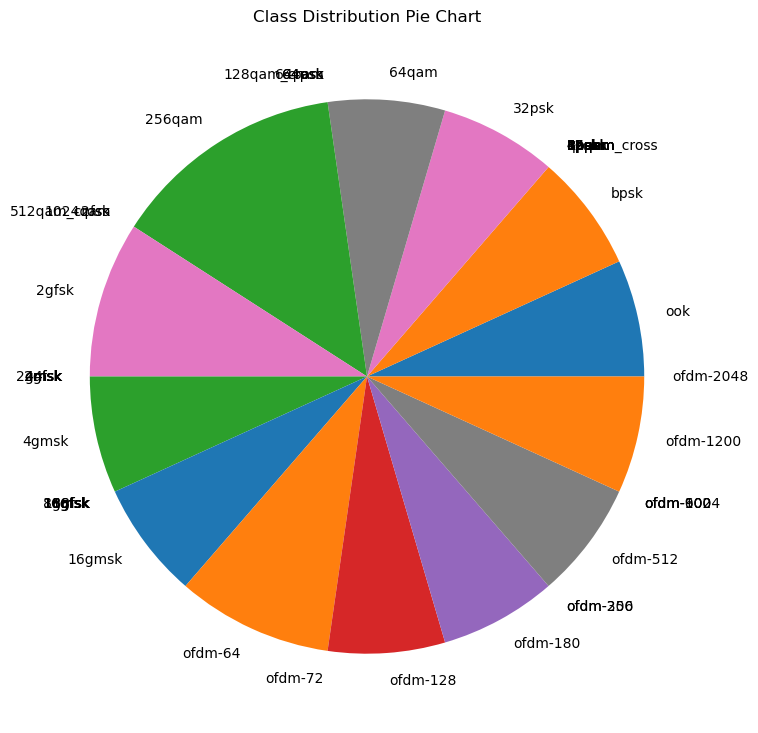

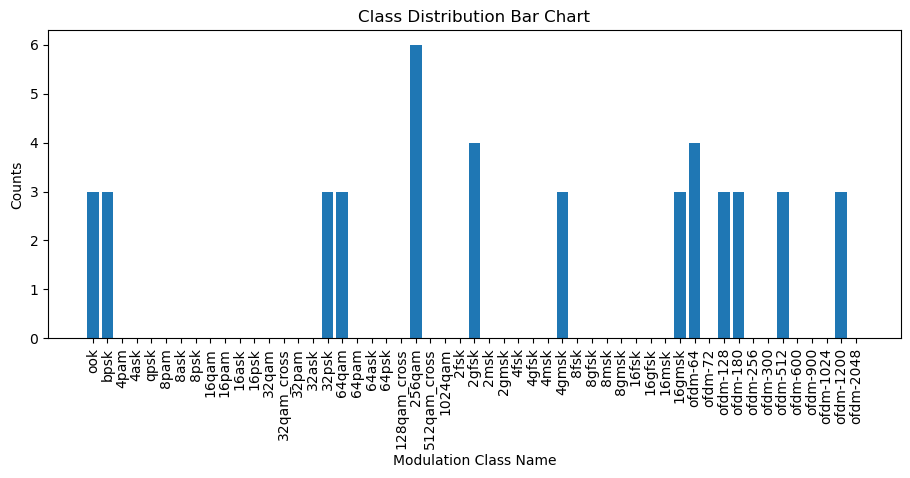

In [37]:
# Plot the distribution of classes
class_names = list(class_counter_dict.keys())
num_classes = list(class_counter_dict.values())

plt.figure(figsize=(9,9))
plt.pie(num_classes, labels=class_names)
plt.title("Class Distribution Pie Chart")
plt.show()

plt.figure(figsize=(11,4))
plt.bar(class_names, num_classes)
plt.xticks(rotation=90)
plt.title("Class Distribution Bar Chart")
plt.xlabel("Modulation Class Name")
plt.ylabel("Counts")
plt.show()